Firstly we need to open file where we saved preprocessed dataset and split it between train and test set.

In [1]:
import numpy as np
import json
import sklearn.model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold


dataset_path = "D:\\Studia\\thesis\\MFCC_data_scaled.json"

#Now we have to split our data between training set, validation set and test set
with open(dataset_path, "r") as jf:
    data = json.load(jf)
    
#MFCCs are our inputs and labels are our targets. Label 1 corresponds to killer whale and label 0 to other animal     
inputs= np.array(data["mfcc"])
targets= np.array(data["label"])


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(inputs, targets, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=42)


orca_samples = inputs[targets == 1]
non_orca_samples = inputs[targets == 0]
print(len(orca_samples))
print(len(non_orca_samples))

# Shapes of the created arrays
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

55820
64595
X_train shape: (86698, 7, 13)
X_val shape: (21675, 7, 13)
X_test shape: (12042, 7, 13)
y_train shape: (86698,)
y_val shape: (21675,)
y_test shape: (12042,)


This script is defining and training the Long Short-Term Memory (LSTM) model for my classification problem. The model is being optimized using a randomized search on hyperparameters.

In [3]:

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import tensorflow
from tensorflow.keras.layers import LSTM, Dense
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier



#This function defines the architecture of the LSTM model. The model is defined as a Sequential model with multiple layers, including LSTM, Dropout, and Dense layers.
def model_f(units=256, dropout=0.2):
    input_shape=(7,13)
    model = keras.Sequential()
    model.add(LSTM(units,input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='Softmax'))
    model.summary()
    model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['acc'])
    return model



#This is a dictionary that defines the grid of hyperparameters for the RandomizedSearchCV.
# param_grid = {'batch_size': [80, 128],
#               'units': [128, 256],
#               'dropout': [0.2, 0.4, 0.5]
#               }
# model_gs = KerasClassifier(model_f, verbose=0)
# random_search = RandomizedSearchCV(estimator=model_gs, param_distributions=param_grid, cv=5)
# random = random_search.fit(X_train, y_train)

# print("Best:  {} using {}" .format(random.best_score_, random.best_params_))

# best_units = random.best_params_['units']
# best_dropout = random.best_params_['dropout']
# best_batch = random.best_params_['batch_size']

# Early stopping callback, which ends training if the validation loss doesn't improve for 5 epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# training the model using optimized parameters and splitted dataset
model = model_f(256, 0.2)
history = model.fit(X_train, y_train, epochs=100, batch_size=80, 
                        validation_data=(X_val, y_val), shuffle=False, callbacks=[early_stop])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 256)               276480    
                                                                 
 dropout_65 (Dropout)        (None, 256)               0         
                                                                 
 dense_65 (Dense)            (None, 128)               32896     
                                                                 
 dropout_66 (Dropout)        (None, 128)               0         
                                                                 
 dense_66 (Dense)            (None, 64)                8256      
                                                                 
 dropout_67 (Dropout)        (None, 64)                0         
                                                                 
 dense_67 (Dense)            (None, 32)              

Cross-validation scores of LSTM acuraccy and their standard deviation

In [ ]:
#cross validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import statistics

model_cv = KerasClassifier(build_fn=model_f, epochs=13, batch_size=80,  verbose=0)
cv_scores = cross_val_score(model_cv, X_train, y_train, cv=5)

print("CV Scores:", cv_scores)
print("Average CV Score:", cv_scores.mean())
sd = np.std(cv_scores)
print("Standard Deviation:", sd)

#Thorough classification report of accuracy. It includes precision, recall and f1-score.
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

Here I visualized confusion matrix of the LSTM results.

377/377 [==============================] - 3s 8ms/step


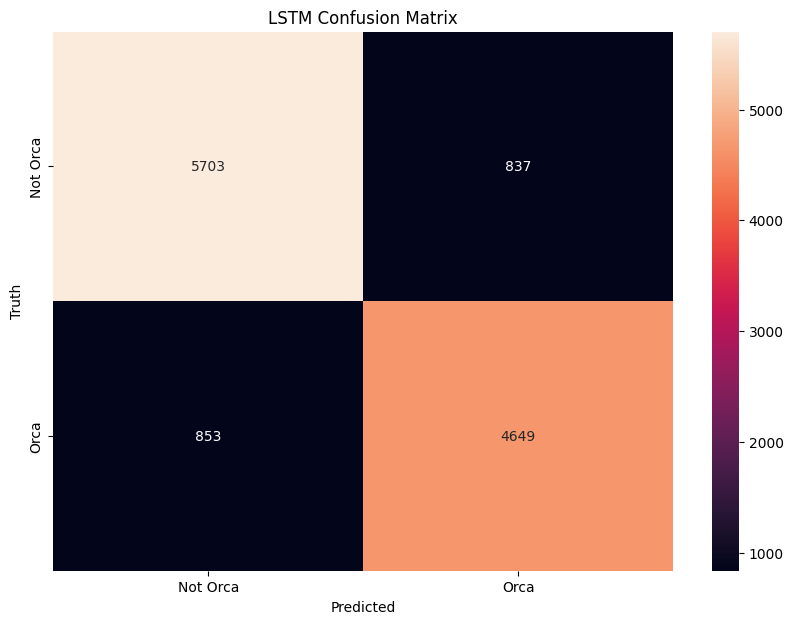

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not Orca', 'Orca'], yticklabels=['Not Orca', 'Orca'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("LSTM Confusion Matrix")

plt.show()

This cell generates a plot showing the model's validation accuracy throughout the training epochs.

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Val-accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

This code cell is fitting a Logistic Regression model to the data, then evaluating its performance through a classification report and cross-validation.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Logistic regression. The reshape() method is used to convert the input data X_train and X_val from a 3D array to a 2D array,
# where the number of rows corresponds to the number of samples, and the number of columns corresponds to the number of features * the number of time steps
X_train_2D = X_train.reshape(X_train.shape[0], -1)
X_test_2D = X_test.reshape(X_test.shape[0], -1)


logreg = LogisticRegression()
logreg.fit(X_train_2D, y_train)

y_pred = logreg.predict(X_test_2D)


In [ ]:
cv_scores = cross_val_score(logreg, X_train_2D, y_train, cv=5)

print(classification_report(y_test, y_pred))
print("Mean CV Accuracy: {:.2f}".format(cv_scores.mean()))
sd = np.std(cv_scores)
print("Standard Deviation:", sd)

Here I visualized confusion matrix of the LR results.

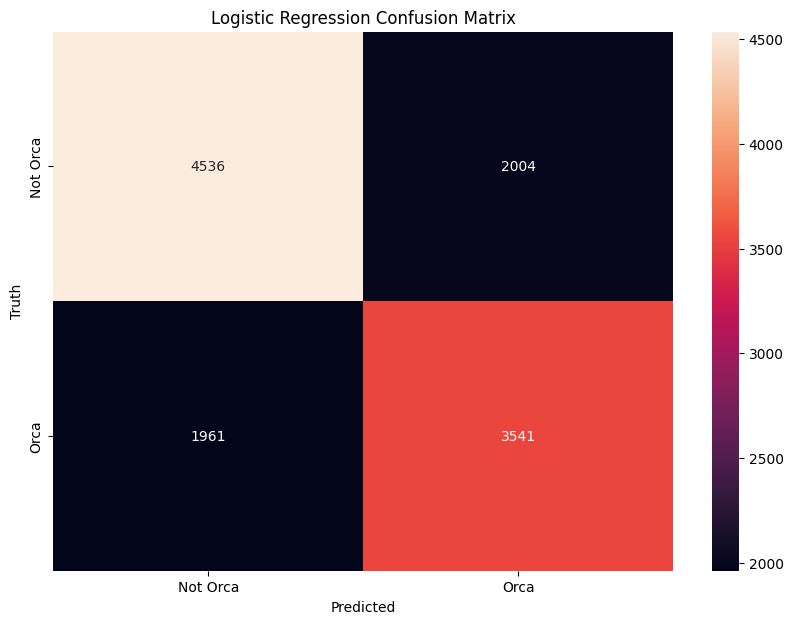

In [19]:
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not Orca', 'Orca'], yticklabels=['Not Orca', 'Orca'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Logistic Regression Confusion Matrix")

plt.show()

This code cell is fitting a K-Nearest Neighbors model to the data, then evaluating its performance through a classification report and cross-validation. Number of neighbors is set to 3.

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, weights='distance' )
knn.fit(X_train_2D, y_train)

y_pred = knn.predict(X_test_2D)


In [ ]:
cv_scores = cross_val_score(knn, X_train_2D, y_train, cv=5)

print(classification_report(y_test, y_pred))
print("Mean CV Accuracy: {:.2f}".format(cv_scores.mean()))
sd = np.std(cv_scores)
print("Standard Deviation:", sd)

Here I visualized confusion matrix of the K-NN results.

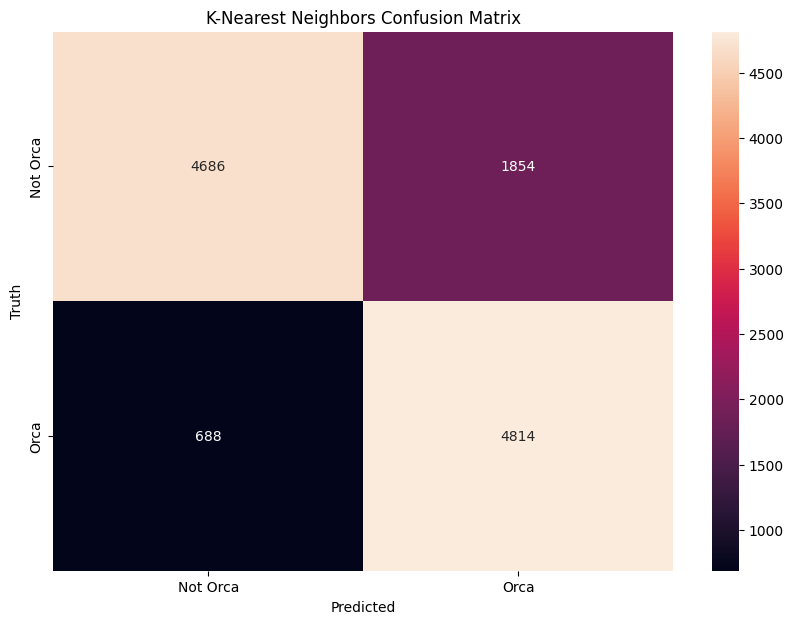

In [21]:
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not Orca', 'Orca'], yticklabels=['Not Orca', 'Orca'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("K-Nearest Neighbors Confusion Matrix")

plt.show()

This code cell is fitting a Random Forest model to the data, then evaluating its performance through a classification report and cross-validation. Classifier model is initialized with 300 trees.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train_2D, y_train)

y_pred = rf.predict(X_test_2D)



In [ ]:
cv_scores = cross_val_score(rf, X_train_2D, y_train, cv=5)

print(classification_report(y_test, y_pred))
print("Mean CV Accuracy: {:.2f}".format(cv_scores.mean()))
sd = np.std(cv_scores)
print("Standard Deviation:", sd)

Here I visualized confusion matrix of the RF results.

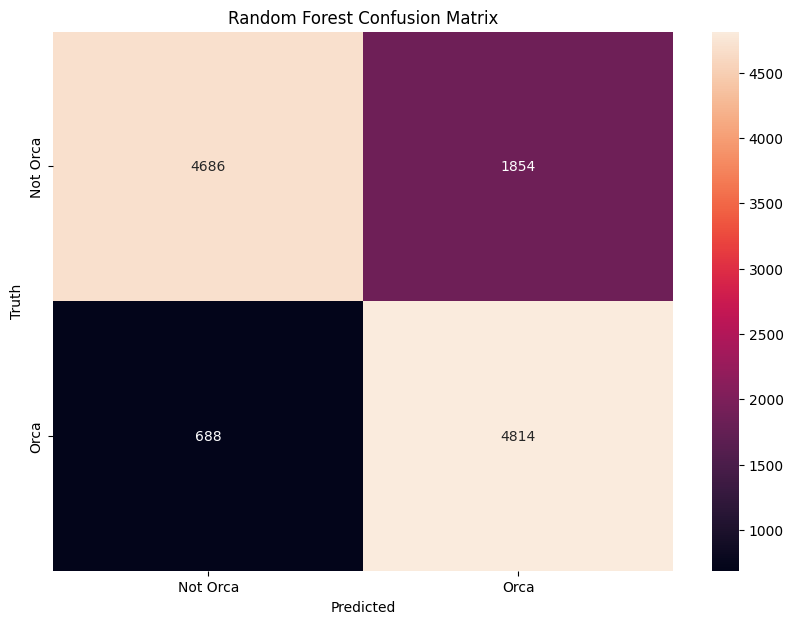

In [22]:
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not Orca', 'Orca'], yticklabels=['Not Orca', 'Orca'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Random Forest Confusion Matrix")

plt.show()

In this code I determine the importance of different MFCC features. For this action I utilized the Random Forest classifier in order to procede with this task.

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train_2D, y_train)

importances = rf.feature_importances_
mfcc_importances = []

print("Feature ranking:")
for i in range(13):
    # Here I get the importances for the current MFCC feature across all timesteps and then I am calculating the average importance of the current MFCC feature
    current_mfcc_importances = importances[i::13]
    avg_importance = np.mean(current_mfcc_importances)
    mfcc_importances.append(avg_importance)
    

# Here I normalize MFCC importances
mfcc_importances = np.array(mfcc_importances)
normalized_mfcc_importances = mfcc_importances / np.sum(mfcc_importances)

summ=0
importances = []
for i, importance in enumerate(normalized_mfcc_importances):
    print("Importance of MFCC Feature {}: {}".format(i+1, importance))
    importances.append(importance)
    summ+=importance
    
print(summ)

Feature ranking:
Importance of MFCC Feature 1: 0.15638739536967172
Importance of MFCC Feature 2: 0.08730692407658615
Importance of MFCC Feature 3: 0.08512296106099267
Importance of MFCC Feature 4: 0.08791169627568625
Importance of MFCC Feature 5: 0.06426432880592148
Importance of MFCC Feature 6: 0.10427349183292671
Importance of MFCC Feature 7: 0.061076086544830495
Importance of MFCC Feature 8: 0.06952361108675627
Importance of MFCC Feature 9: 0.05689059447413686
Importance of MFCC Feature 10: 0.0638414257230399
Importance of MFCC Feature 11: 0.05272433089378081
Importance of MFCC Feature 12: 0.05851515713329367
Importance of MFCC Feature 13: 0.052161996722377243
1.0000000000000002


The code cell below generates a plot showing contribution of each MFCC in model training

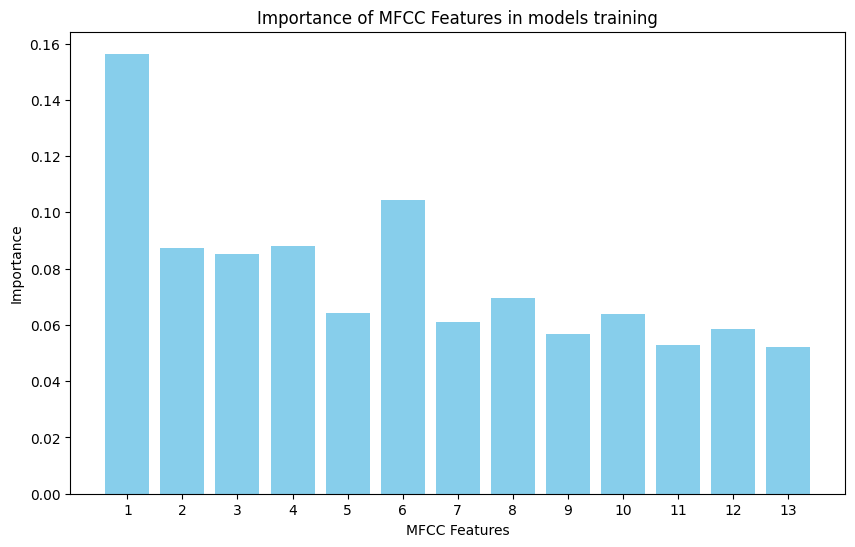

In [34]:
coef = range(1, 14)
plt.figure(figsize=(10, 6))
plt.bar(coef, importances, color='skyblue')
plt.xlabel('MFCC Features')
plt.ylabel('Importance')
plt.title('Importance of MFCC Features in models training')
plt.xticks(coef)
plt.show()

In cell below I am extracting feature importances from the Random Forest model. Firstly I am prepairing the frequency, duration and pitch for model training, in order to evaluate the contribution of each feature in this training.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

#Here, the input variables ('frequency', 'duration', 'pitch') are reshaped from 1D arrays to 2D arrays. This is done because Scikit-learn expects 2D inputs for its models.
inputs_frequency = np.array(data["frequency"]).reshape(-1, 1)
inputs_duration = np.array(data["duration"]).reshape(-1, 1)
inputs_pitch = np.array(data["pitch"]).reshape(-1, 1)

#The inputs are then concatenated along the second dimension to form a single 2D input array. 
# inputs is now an array where each row corresponds to a sample and each column corresponds to a feature.
inputs = np.concatenate((inputs_frequency, inputs_duration, inputs_pitch), axis=1)
targets= np.array(data["label"])

# feature normalisation
scaler = StandardScaler()
inputs = scaler.fit_transform(inputs)

#Splitting the data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(inputs, targets, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# feature importances
importances = model.feature_importances_

#Here we assign the importances to corresponding features
frequency_importance = importances[0]  
duration_importance = importances[1]  
pitch_importance = importances[2]  

print("Frequency importance: ", frequency_importance)
print("Duration importance: ", duration_importance)
print("Pitch importance: ", pitch_importance)

Frequency importance:  0.17535321768638085
Duration importance:  0.30292787868754906
Pitch importance:  0.5217189036260701


This block of code is creating a pie chart to visualize the relative importance of the features - "Frequency", "Duration", and "Pitch", which were calculeted in the cell above

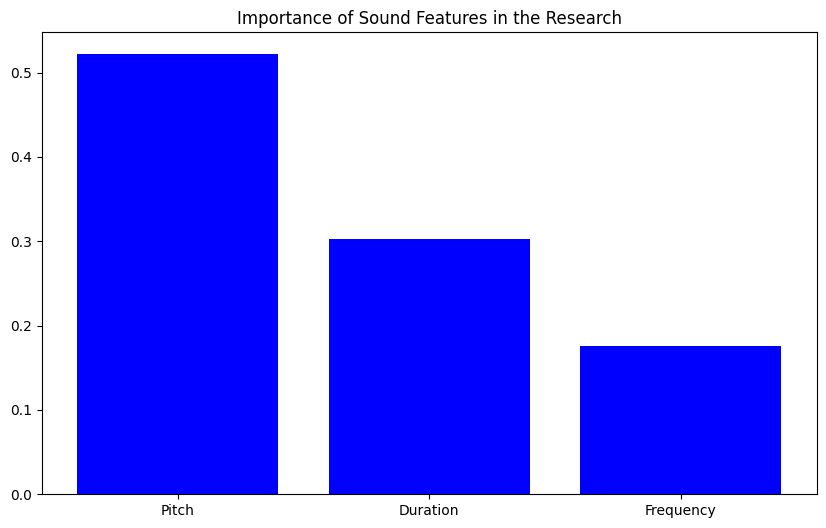

In [32]:
features = ["Pitch","Duration","Frequency"  ]

# Corresponding importances
importances = [pitch_importance, duration_importance, frequency_importance  ]

plt.figure(figsize=(10, 6))
plt.bar(features, importances, color=['blue'])
plt.xlabel("")
plt.ylabel("")
plt.title('Importance of Sound Features in the Research')
plt.show()

The last thing we want to visualize is the average of cross validation scores for different machine learning models. Below the bar plot is created for every model used in this thesis.

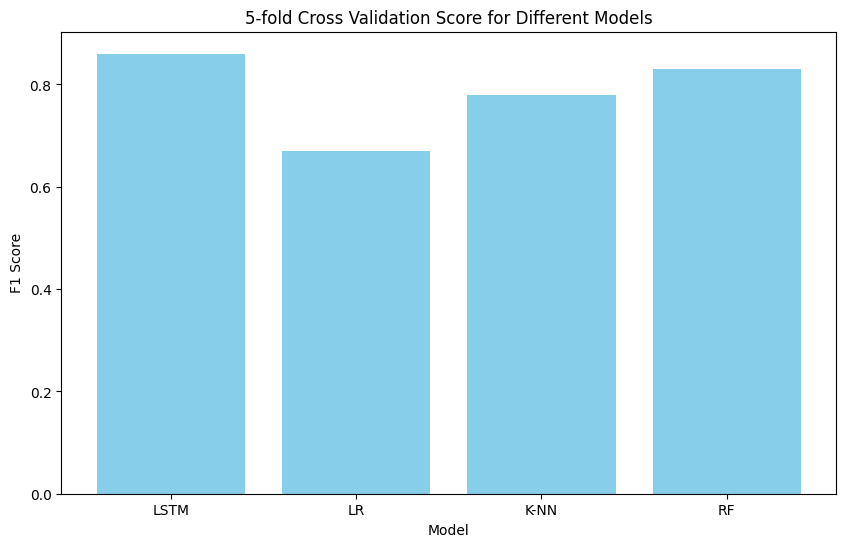

In [12]:
models = ["LSTM", "LR", "K-NN", "RF"]

# Corresponding F1 scores
f1_scores = [0.86, 0.67, 0.78, 0.83]

plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color='skyblue')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('5-fold Cross Validation Score for Different Models')
plt.show()

visualization of test scores for different machine learning models

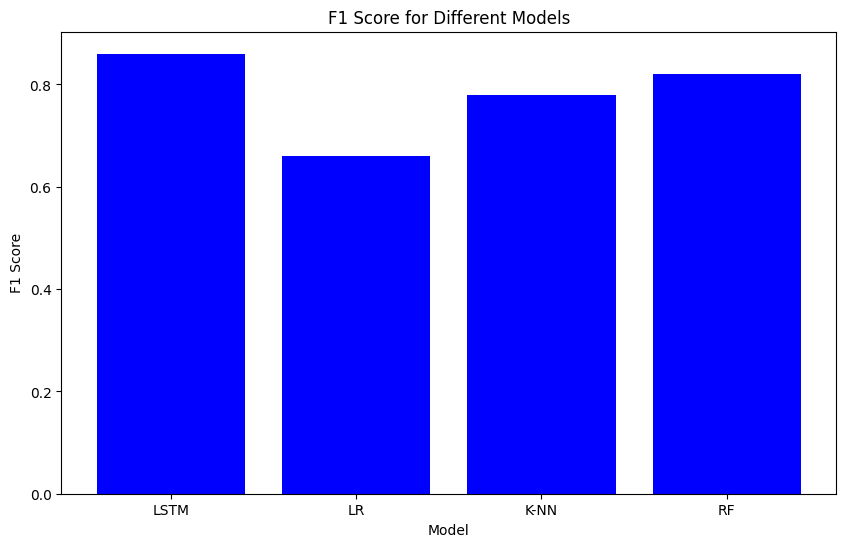

In [13]:
models = ["LSTM", "LR", "K-NN", "RF"]

# Corresponding F1 scores
f1_scores = [0.86, 0.66, 0.78, 0.82]

plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color='blue')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Models')
plt.show()